# MLiM 25440 Homework 7
### Brendan Sanderson

#### Imports and Data Loading

In [0]:
#General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import math

#SKLearn Imports
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import compute_class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

#Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils
import keras
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Dropout
pd.set_option('use_inf_as_na', True)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
muv = pd.read_csv("/content/drive/My Drive/MLiM-Datasets/HW7/muv.csv")
muv_data = muv.drop(columns=['mol_id','smiles'])

In [0]:
#Load the features.
print('\r', 'Datasets Loaded: 0 / 4', end='')
fp256 = pd.read_csv("/content/drive/My Drive/MLiM-Datasets/HW7/muv_fp256.csv", index_col=0)
print('\r', 'Datasets Loaded: 1 / 4', end='')
fp1024 = pd.read_csv("/content/drive/My Drive/MLiM-Datasets/HW7/muv_fp1024.csv", index_col=0)
print('\r', 'Datasets Loaded: 2 / 4', end='')
fp4096 = pd.read_csv("/content/drive/My Drive/MLiM-Datasets/HW7/muv_fp4096.csv", index_col=0)
print('\r', 'Datasets Loaded: 3 / 4', end='')
mordred = pd.read_csv("/content/drive/My Drive/MLiM-Datasets/HW7/muv_mordred.csv", index_col=0)
print('\r', 'Datasets Loaded: 4 / 4', end='')

 Datasets Loaded: 4 / 4

## 1. Feature extraction and data processing

#### Question 1.1
Before you continue, could you guess which feature(s) will perform the best, based on the documents? Please write down the reasons behind your guess. There is no “correct” answer to this question.

I expect the mordred features to perform the best. This is because the fingerprints only contain binary data related to the structure of the proteins. The mordred dataset contains about 1800 different descriptors that contain float information. This includes a variety of descriptors that relate to much more than just structural information. Thus, the mordred features contains far more data than any of the fingerprints do and I expect that it will perform the best.

Of the fingerprints, I expect that fp4096 will perform the best because it has the largest fingerprint. It would make sense for the larger fingerprint to produce better results as it contains more columns and thus more descriptive data about the ligands.

#### Question 1.2
Plot the histogram(s)/bar plot(s) of the number of entries, the number of actives and the ratios of actives for each ​target​. You can either put all the statistics in the same figure, or three seperate ones.

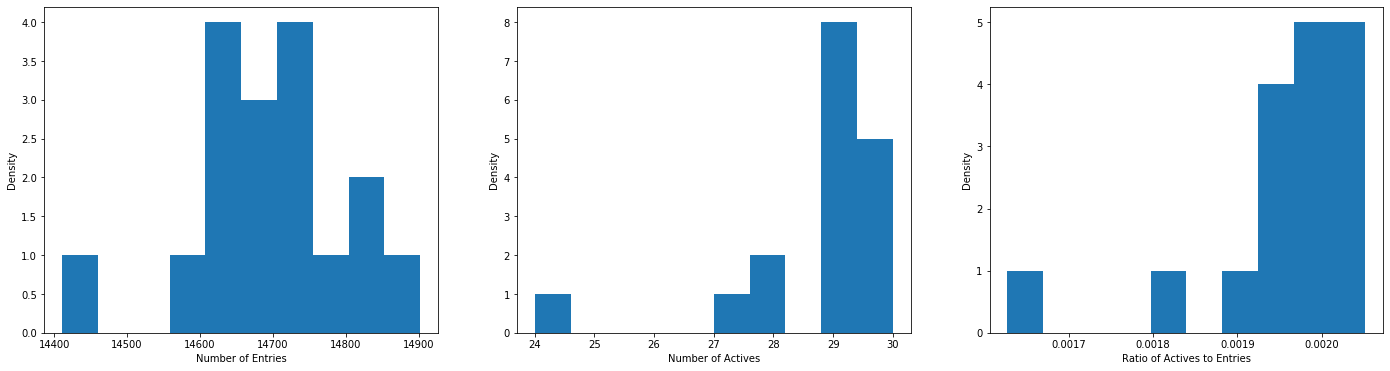

In [0]:
#Calculate the statistics.
target_entries = muv_data.count(axis=0)
target_actives = muv_data.sum(axis=0)
target_ratios = target_actives/target_entries

#Plot the histograms
plt.figure(figsize=(24,6))
for i,(xlab,data) in enumerate(zip(["Number of Entries", "Number of Actives", "Ratio of Actives to Entries"],[target_entries,target_actives, target_ratios])):
  plt.subplot(1,3,i+1)
  plt.ylabel("Density")
  plt.xlabel(xlab)
  plt.hist(data)
plt.show()

#### Question 1.3
Plot the histogram(s) of the number of entries, the number of actives and the ratios of actives for each ​ligand​. You can either put all the statistics in the same figure, or three seperate ones.

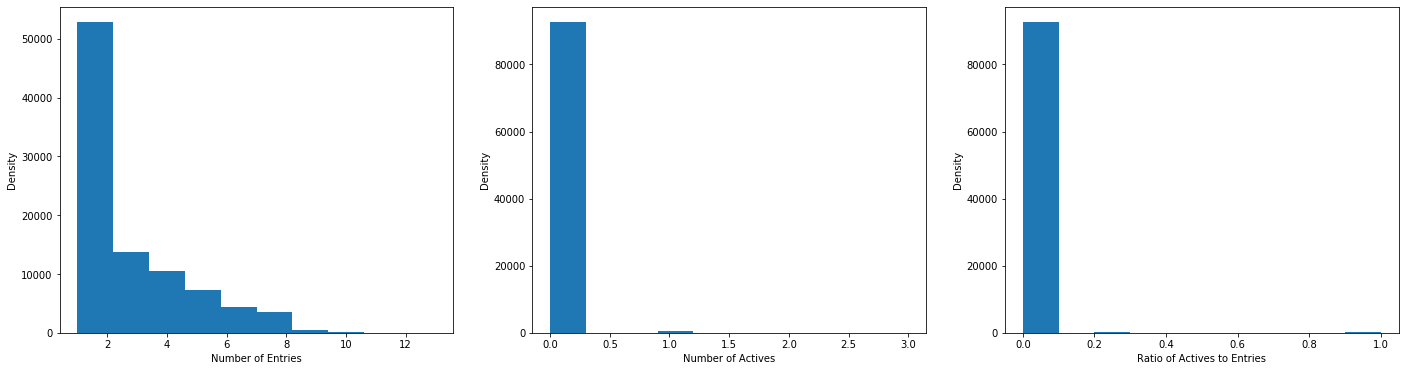

In [0]:
#calulate the statistics
ligand_entries = muv_data.count(axis=1)
ligand_actives = muv_data.sum(axis=1)
ligand_ratios = ligand_actives/ligand_entries

#Plot the histograms
plt.figure(figsize=(24,6))
for i,(xlab,data) in enumerate(zip(["Number of Entries", "Number of Actives", "Ratio of Actives to Entries"],[ligand_entries,ligand_actives, ligand_ratios])):
  plt.subplot(1,3,i+1)
  plt.ylabel("Density")
  plt.xlabel(xlab)
  plt.hist(data)
plt.show()

## 2. Model comparison

Now pick the column (target) with the most number of entries and build 4 deep learning models for this single-task binary classification problem, using the 4 different features you have obtained in part 1. Remember to scale/normalize the input features before training.
You can use the same network configuration (except for the input layer of course) for all the models, and train them with enough epochs to make sure the training loss stabilizes. Report the ROC AUC of these 4 features.


In [0]:
#Pick the column with the most enteries.
target_column = max(list(zip(muv_data.count(axis=0),muv_data.columns)), key= lambda x: x[0])[1]
y = np.rint(muv_data[target_column])
y = y.astype(int)
#Filter out the values in each dataset that do not have an entry in the target column.
filt = [math.isnan(a)==False for a in y]
fp256_f, fp1024_f, fp4096_f, mordred_f, y = fp256[filt], fp1024[filt], fp4096[filt], mordred[filt], np.array(y[filt])

#Drop the na values and normalize the datasets.
mordred_f = mordred_f.dropna(axis=1)
scaler1, scaler2, scaler3, scaler4 = preprocessing.StandardScaler(), preprocessing.StandardScaler(), preprocessing.StandardScaler(), preprocessing.StandardScaler()
fp256_f, fp1024_f, fp4096_f, mordred_f = scaler1.fit_transform(fp256_f),scaler2.fit_transform(fp1024_f), scaler3.fit_transform(fp4096_f),scaler4.fit_transform(mordred_f)

In [0]:
#network that will be used for the classification of the datasets.
def nn_model(i):
  model = models.Sequential()
  model.add(layers.InputLayer(i,))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
#Function to run test train split and then train and test the model, returning the results.
def nn_auc_test(model, X, y, eps, cw =  {0:1,1:100}):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
  hist = model.fit(x=X_train, y=y_train, epochs=eps, batch_size=256, shuffle=True, verbose = 0, class_weight = cw)
  y_hat = model.predict(X_test)
  auc = roc_auc_score(y_test, y_hat)
  fpr, tpr, thresholds = roc_curve(y_test, y_hat)
  return auc, fpr, tpr

In [0]:
#Run train and test the model for each dataset
results = []
for i,d in enumerate([fp256_f, fp1024_f, fp4096_f, mordred_f]):
  print("Running dataset", i+1, "/ 4")
  results.append(nn_auc_test(nn_model(d.shape[1]),d,y, eps = 100))

Running dataset 1 / 4
Running dataset 2 / 4
Running dataset 3 / 4
Running dataset 4 / 4


In [0]:
for r,n in zip(results,["fp256", "fp1024", "fp4096", "mordred"]):
  print("The ROC AUC for", n, "is", r[0])

The ROC AUC for fp256 is 0.5667226890756303
The ROC AUC for fp1024 is 0.6461624649859943
The ROC AUC for fp4096 is 0.7054341736694677
The ROC AUC for mordred is 0.7287394957983194


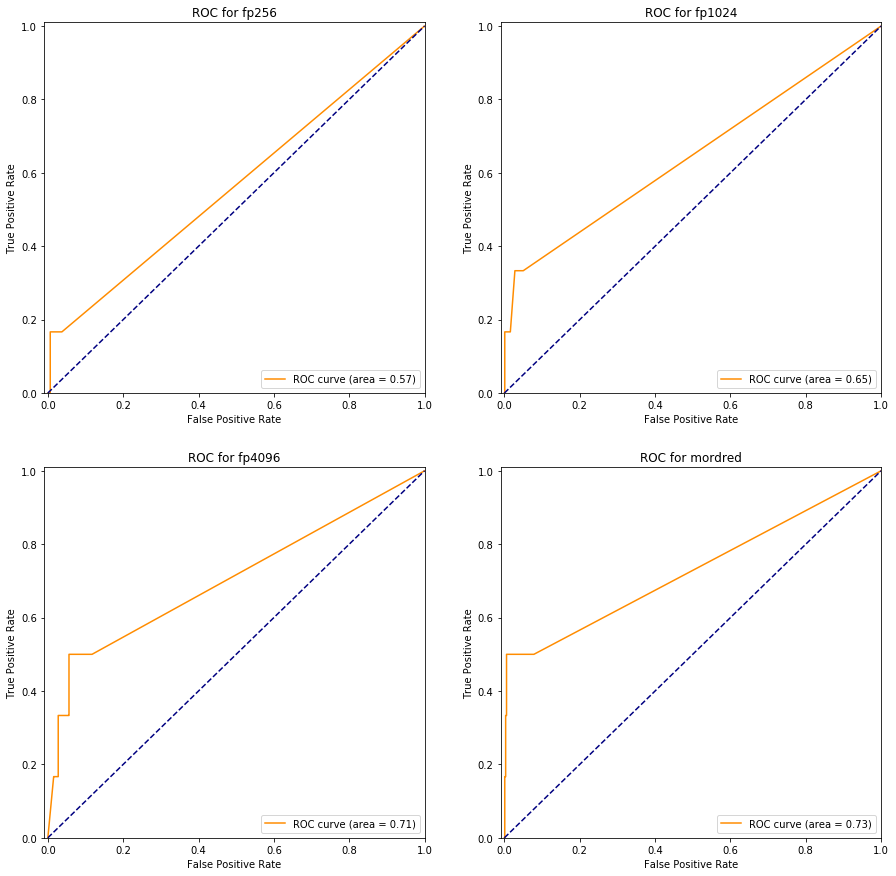

In [0]:
#Plot the roc curves for each feature.
plt.figure(figsize=(15,15))
for i,(r,n) in enumerate(zip(results,["fp256", "fp1024", "fp4096", "mordred"])):
  plt.subplot(2,2,i+1)
  plt.plot(r[1], r[2], color='darkorange', label='ROC curve (area = %0.2f)' % r[0])
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([-0.01, 1.0])
  plt.ylim([0.0, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for ' + n)
  plt.legend(loc="lower right")
plt.show()


#### Question 2.1
Based on your research and understanding, why do you think normalization is often required for neural networks? And which feature(s) is more likely to yield bad performance without normalization?


Normalization is often required because different columns have different ranges of values and different variations of values. We don't want columns with a larger range of values to have a larger inpact on the data than a column with a lower range of values. Thus, by normalizing the data, the range of values is the same for all of the columns and thus they are treated equally by the model.

The modred dataset is likely to yield bad performance without normalization because it contains columns with a lot of ranges. Thus, without normalization, the model would tend to favorite certain columns over others, which is not the behavior we want as all columns should be treated equally important. If a column had a lot of predictive power, but had an extremely small range, it would be exlcuded from the dataset, which is not what we would want.

#### Question 2.2
Based on the plots from part 1, why do you think ROC AUC is the better metric for this classification problem, instead of accuracy?

The histograms in question 1 show that each target has less that 0.25% active responses. Thus, if we randomly guessed inactive for all of the values, we would have an accouracy of 0.25%. This is already an incredible accuracy and it would be extremely hard to get a better accuracy than this. This signifies that it is far more important to get the true positives correct due to this extreme class imbalance. Accuracy does not indicate how well the model performed at correctly guessing the true values. The ROC curve tells us the true positive rate versus the false positive rate at different thresholds. By taking the AUC of the ROC, we get an overall indicator of the true positive vs false positive rate. Thus, this value is a better metric as it tells us how well the model was at predicting active responses, which is the important indicator of model quality.

#### Question 2.3
Which one of the 4 features has the best ROC AUC according to your results?

1. mordred
2. fp4096
3. fp1024
4. fp256

This results were what I expected given that mordred has the most complex and variable data. Also, each fingerprint with a lower dimension size represents the same thing, just with less data, so it makes sense that fp4096 had the most and fp256 had the least.

#### Question 2.4
If all the entries in the all columns/targets are used during the training, would you expect the prediction performance (of the specific target that you have chosen) to increase or decrease, and why? Again there is no “correct” answer here.

I would expect this to decrease the prediction performance. It is likely not the case that similar configurations of ligands lead to positive active responses for different receptors as different ligands only have active responses for at most a couple of receptors. Thus, adding data related to the response of different receptors likely does not increase the quality of the model as there does not appear to be a relationship because active responses of different receptors for the same ligand. This implies that adding all of the targets only complicates the classification problem, making it harder to solve and generalize. A specialized model that focuses on a single target definitely seems to be easier.

#### Now use all the columns/targets in the MUV dataset, and the best features you find from the previous comparison, to construct a neural network for this binary classification problem. An easy way to do this is to construct a network with two sets of inputs: the first one being the features of the ligands, and the second one is the one-hot encoding of the receptor.

In [0]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, features, encodings, batch_size=32, dim1 = 1242, dim2 = 17):
        self.dim1 = dim1
        self.dim2 = dim2
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.features = features
        self.encodings = encodings
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    #getitem is called when the keras training calls for a batch
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        #Shuffle the data at the end of each epoch
        self.indexes = np.arange(len(self.list_IDs))
        np.random.shuffle(self.indexes)

    #data_generation generates the X an y data. The X data is stored as 2 seperate arrays. 1 for the mordred dataset and 1 for the one hot encoding
    def __data_generation(self, list_IDs_temp):
        X1 = np.empty((self.batch_size, self.dim1))
        X2 = np.empty((self.batch_size, self.dim2))
        y = np.empty((self.batch_size))

        for i, ID in enumerate(list_IDs_temp):
            #Get the mordred features
            X1[i,] = self.features[ID[0]]
            #Get the one hot encoding features
            X2[i,] = self.encodings[ID[1]].flatten()
            y[i] = self.labels[ID[1]][ID[0]]
        return [X1,X2], y

In [0]:
#The conatenation model
def nn_dg_concat_model(i):
  #It has two inputs: the mordred features and the one hot encoding.
  ds_input = Input((i,))
  oh_input = Input((17,))
  dense1 = Dense(256, activation='relu')(ds_input)
  #Concatenate the inputs after one dense layer
  concat = Concatenate()([dense1, oh_input])
  dropout1 = Dropout(0.1)(concat)
  dense2 = Dense(128, activation='relu')(dropout1)
  dense3 = Dense(64, activation='relu')(dense2)
  dropout2 = Dropout(0.1)(dense3)
  dense4 = Dense(16, activation='relu')(dropout2)
  output = Dense(1, activation='sigmoid')(dense4)
  model = Model(inputs=[ds_input,oh_input], outputs=output)
  model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
#make a row for each ligand, receptor pair and drop the pairs that do not have an entry.
muv_encodings = muv_data.copy()
muv_encodings.insert(0,"LigandID", range(muv_encodings.shape[0]))
muv_encodings = pd.DataFrame(muv_encodings.melt(id_vars="LigandID").dropna().values, columns = ["LigandID","ReceptorID", "Active"])

#ligand_receptor_IDs is the list of all ligand receptor pairs that have an entry
ligand_receptor_IDs = muv_encodings.values[:,:2]
#muv_y is the y value for each index in ligand_receptor_IDs
muv_y = muv_encodings.values[:,2].flatten().astype(int)

#recepgtor encodings will become the one hot encoding dictionary
receptor_encodings = {}
for i,rep in enumerate(muv_data.columns):
  receptor_encodings[rep] = utils.to_categorical([i], num_classes=len(muv_data.columns))

#Drop the na values and normalize the dataset
mordred_data = mordred.dropna(axis=1)
scaler = preprocessing.StandardScaler()
mordred_data = scaler.fit_transform(mordred_data)

In [0]:
#Runs test train split and trains the model with given parameters.
def datagen_nn_auc_test(model, datagen_params, X, y, eps, cw = {0:1,1:100}):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
  train_generator = DataGenerator(X_train, **datagen_params)
  test_generator = DataGenerator(X_test, **datagen_params)
  model.fit_generator(train_generator, epochs=eps, class_weight = cw, verbose = 0)
  y_hat = model.predict_generator(test_generator)
  auc = roc_auc_score(y_test[:len(y_hat)], y_hat)
  fpr, tpr, thresholds = roc_curve(y_test[:len(y_hat)], y_hat)
  return auc, fpr, tpr

In [0]:
#Run the model and get the results

#Params are the parameters that will be used for the data generators.
params = {'dim1': mordred_data.shape[1],
          'batch_size': 512,
          'labels': muv_data,
          'features': mordred_data,
          'encodings': receptor_encodings}
model = nn_dg_concat_model(params['dim1'])
results = datagen_nn_auc_test(model, params, ligand_receptor_IDs, muv_y, eps = 5)

In [0]:
print("The ROC AUC score is", results[0])

The ROC AUC score is 0.5482977088713148


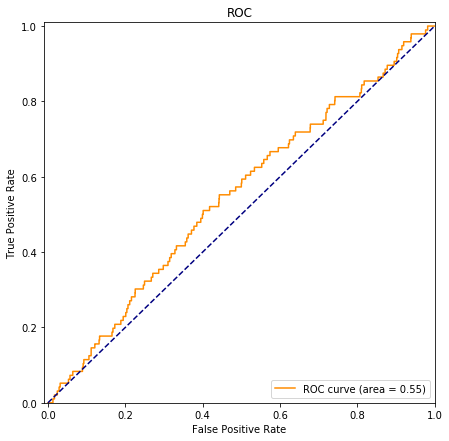

In [0]:
#Plot the ROC curve
plt.figure(figsize=(7,7))
plt.plot(results[1], results[2], color='darkorange', label='ROC curve (area = %0.2f)' % results[0])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

#### Question 2.5
What is the ROC AUC of all the labels and the one specific receptor/target that you have picked in the previous run? Compare your results to the some of the ​latest results​ from MoleculeNet.

MoleculeNet obtained a AUC ROC of 0.693 with vanilla tensorflow and an overall best of 0.775. I was not able to produce results that competed with these, but it is interesting to see how even experts struggle to come up with a model that is a strong predictor of active/inactive entries in MUV. I was only able to get an ROC AUC of 0.55. I tried an emormous amount of different configurations of networks, epochs and batch sizes and was unable to get a better score than this. This truly shows how difficult of a task this is as expects can't even achieve a strong ROC AUC score.

## Write Up

In part 1 of the homework, I saw the immense difficulty of attemption to predict active/inactive responses of receptor proteins on ligands. The issue is that it is so hard to collect data on ligands. There are less than 15,000 entries of each receptor protein and there are over 90,000 ligands. In addition, determine an active receptor protein is even more difficult. For each ligand, less thank 0.2% of the recording entries exhibit an active reliationship. This is an extremely low amount and creates a serious class inbalance, which makes the dataset extremely fragile and thus extremely difficult to analysis as just guessing false gives a 99.8% accuracy rate.

In part 2, I attempted to create models to predict the active/inactive entries and was able to get hands on experience of how difficult this actually is. When creating a model for a single receptor, the model was extremely fragile. A small change of even the dropout would have a significant impact on the AUC value. It was cool to play about with class balancing tactics such as stratifying and class weights. It was really cool to see how much of an impact these two things had on the AUC. It is clear that class inbalance is a serious issue and class distribution should always be checked before creating a model. This is something I had no prior experience with and thus really enjoyed this part of the lab. The 2nd part of part 2 where we attempted to predict all of the receptors with 1 model was extremely difficult. Between the hot encoding input concatenation and the extreme class imbalance, I found the model to be near impossible to get to a healthy state where it yielded desired results. I found myself tweaking small parts of the model and weights almost as a guess and check to try to determine what would generate a strong AUC. I tried twaeking the network, the batch size, the generator, the number of epochs and still was not able to produce strong results. Overall, this demonstrated to me how difficult it is to create a model for active/inactive responses for receptor ligand pairs.

This clearly shows to me how the power of machine learning is drastically determined by the strength of the data. In this case, the data is extremely weak as demonstrated in part 1 simply because it is hard data to gather. In the future, I am sure that an innovative method to determine active/inactive responses will surface and this classification problem will become trivial. However, currently this method does not exist and we have to make due with the best approach we have, which is the problem we are trying to solve here.